# Task 2: Exploratory Data Analysis (EDA)

This notebook explores patterns, relationships, and drivers of **Access** and **Usage** indicators, with a focus on the 2021–2024 slowdown and recent 2025 supply-side changes.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Locate repo root
cwd = Path.cwd().resolve()
root = None
for parent in [cwd] + list(cwd.parents):
    if (parent / "data" / "raw" / "ethiopia_fi_unified_data.csv").exists() or (parent / "data" / "processed" / "ethiopia_fi_enriched_data.csv").exists():
        root = parent
        break

if root is None:
    raise FileNotFoundError("Could not locate data directory from current working directory.")

raw_path = root / "data" / "raw" / "ethiopia_fi_unified_data.csv"
processed_path = root / "data" / "processed" / "ethiopia_fi_enriched_data.csv"

# Prefer processed enriched data if available
if processed_path.exists():
    df = pd.read_csv(processed_path)
    data_source = "processed"
else:
    df = pd.read_csv(raw_path)
    data_source = "raw"

print("Loaded:", data_source, "shape:", df.shape)

df.head()


Loaded: processed shape: (57, 34)


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,...,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN


## 1) Overview and Basic Counts
Record types, pillars, and temporal coverage.

In [2]:
df["record_type"].value_counts()


record_type
observation    41
event          11
target          3
impact_link     2
Name: count, dtype: int64

In [3]:
obs = df[df["record_type"] == "observation"].copy()

obs["pillar"].value_counts(dropna=False)


pillar
ACCESS           24
USAGE            12
GENDER            4
AFFORDABILITY     1
Name: count, dtype: int64

In [4]:
obs["observation_date"] = pd.to_datetime(obs["observation_date"], errors="coerce")
print("Observation date range:", obs["observation_date"].min(), "to", obs["observation_date"].max())


Observation date range: 2014-12-31 00:00:00 to 2025-12-31 00:00:00


## 2) Access vs Supply-Side Growth (Stagnation)
Compare account ownership to rapid mobile money registration growth.

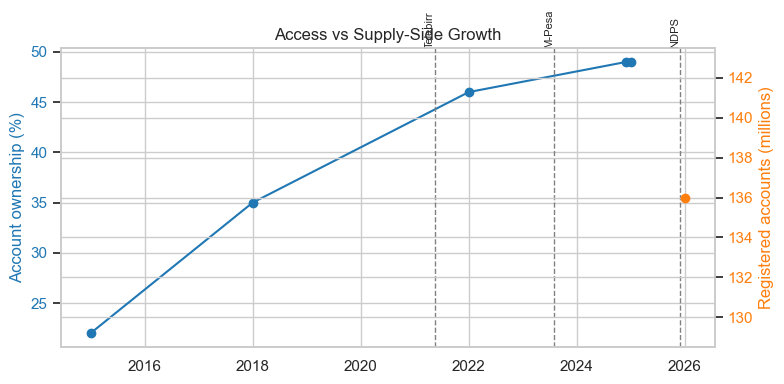

In [5]:
acc = obs[(obs["indicator_code"] == "ACC_OWNERSHIP") & (obs["gender"] == "all") & (obs["location"] == "national")].copy()
acc = acc.sort_values("observation_date")

mm_reg = obs[obs["indicator_code"] == "SUP_MM_REGISTERED_ACCOUNTS"].copy()
mm_reg = mm_reg.sort_values("observation_date")

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(acc["observation_date"], acc["value_numeric"], marker="o", color="tab:blue", label="Account ownership (%)")
ax1.set_ylabel("Account ownership (%)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(mm_reg["observation_date"], mm_reg["value_numeric"] / 1e6, marker="o", color="tab:orange", label="Mobile money registered (M)")
ax2.set_ylabel("Registered accounts (millions)", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

for event_date, label in [("2021-05-17", "Telebirr"), ("2023-08-01", "M-Pesa"), ("2025-12-01", "NDPS")]:
    dt = pd.to_datetime(event_date)
    ax1.axvline(dt, color="gray", linestyle="--", linewidth=1)
    ax1.text(dt, ax1.get_ylim()[1], label, rotation=90, va="bottom", ha="right", fontsize=8)

plt.title("Access vs Supply-Side Growth")
plt.tight_layout()
plt.show()


## 3) Gender and Urban–Rural Gaps
Disaggregations for 2024 account ownership.

C:\Users\hp\AppData\Local\Temp\ipykernel_15028\3717765270.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender, x="gender", y="value_numeric", ax=axes[0], palette="Blues")
C:\Users\hp\AppData\Local\Temp\ipykernel_15028\3717765270.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=urb_rur, x="location", y="value_numeric", ax=axes[1], palette="Greens")


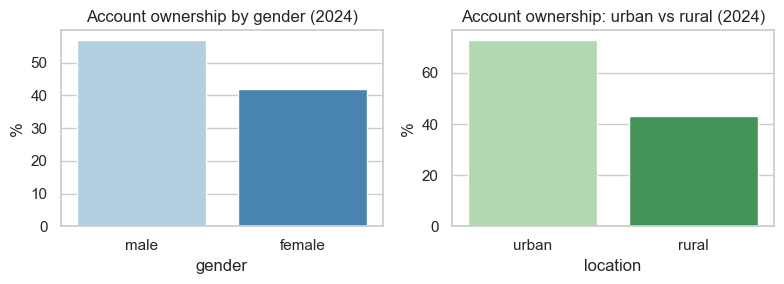

In [6]:
acc_2024 = obs[(obs["indicator_code"] == "ACC_OWNERSHIP") & (obs["fiscal_year"].astype(str) == "2024")].copy()

# Gender
gender = acc_2024[acc_2024["gender"].isin(["male", "female"])][["gender", "value_numeric"]]

# Urban/rural
urb_rur = acc_2024[acc_2024["location"].isin(["urban", "rural"])][["location", "value_numeric"]]

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

sns.barplot(data=gender, x="gender", y="value_numeric", ax=axes[0], palette="Blues")
axes[0].set_title("Account ownership by gender (2024)")
axes[0].set_ylabel("%")

sns.barplot(data=urb_rur, x="location", y="value_numeric", ax=axes[1], palette="Greens")
axes[1].set_title("Account ownership: urban vs rural (2024)")
axes[1].set_ylabel("%")

plt.tight_layout()
plt.show()


## 4) Usage vs Enablers (Agents, Internet)
Explore relationships between usage and infrastructure proxies.

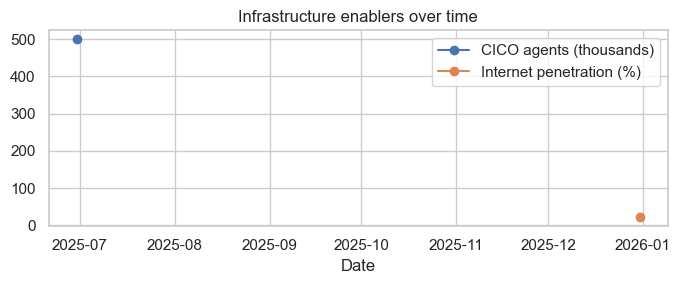

In [7]:
usage = obs[obs["pillar"].eq("USAGE")].copy()

# Example: usage activity rate and enablers
active_rate = usage[usage["indicator_code"] == "USG_ACTIVE_RATE"]["value_numeric"]

agents = obs[obs["indicator_code"] == "SUP_CICO_AGENTS"][["observation_date", "value_numeric"]].copy()
internet = obs[obs["indicator_code"] == "ACC_INTERNET_PEN"][["observation_date", "value_numeric"]].copy()

fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(agents["observation_date"], agents["value_numeric"] / 1000, marker="o", label="CICO agents (thousands)")
ax.plot(internet["observation_date"], internet["value_numeric"], marker="o", label="Internet penetration (%)")
ax.set_title("Infrastructure enablers over time")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()


## 5) Event Timeline Overlays
Contextualize trends with key policy/market events.

Events:
- Telebirr Launch
- Safaricom Ethiopia Commercial Launch
- M-Pesa Ethiopia Launch
- Fayda Digital ID Program Rollout
- Foreign Exchange Liberalization
- P2P Transaction Count Surpasses ATM
- M-Pesa EthSwitch Integration
- EthioPay Instant Payment System Launch
- NFIS-II Strategy Launch
- Safaricom Ethiopia Price Increase
- National Digital Payments Strategy 2026-2030


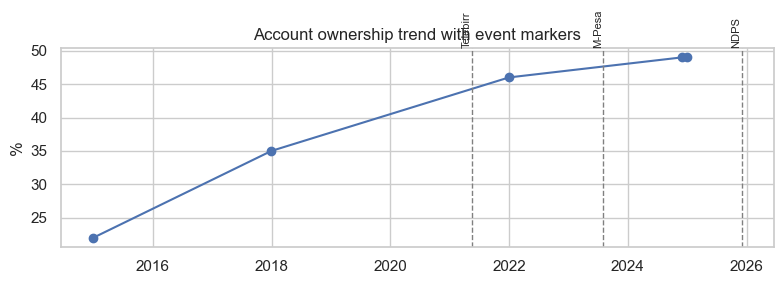

In [8]:
events = df[df["record_type"] == "event"]["indicator"].dropna().unique()
print("Events:")
for e in events:
    print("-", e)

# Timeline overlay on account ownership
plt.figure(figsize=(8, 3))
plt.plot(acc["observation_date"], acc["value_numeric"], marker="o")
plt.title("Account ownership trend with event markers")
plt.ylabel("%")

for event_date, label in [("2021-05-17", "Telebirr"), ("2023-08-01", "M-Pesa"), ("2025-12-01", "NDPS")]:
    dt = pd.to_datetime(event_date)
    plt.axvline(dt, color="gray", linestyle="--", linewidth=1)
    plt.text(dt, plt.ylim()[1], label, rotation=90, va="bottom", ha="right", fontsize=8)

plt.tight_layout()
plt.show()


## 6) Correlations (Numeric Indicators)
A quick look at numeric correlations (limited by sparse time points).

C:\Users\hp\AppData\Local\Temp\ipykernel_15028\2289376051.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


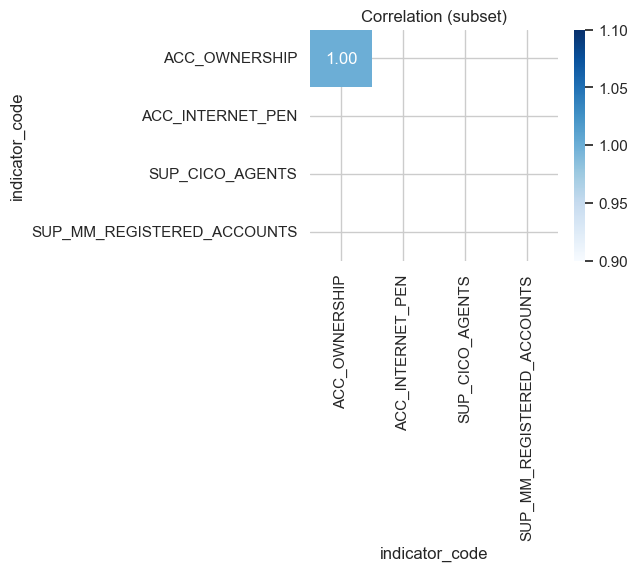

In [9]:
num = obs.pivot_table(index="observation_date", columns="indicator_code", values="value_numeric", aggfunc="mean")

# Focus on a small set of indicators
focus_cols = [c for c in ["ACC_OWNERSHIP", "ACC_INTERNET_PEN", "SUP_CICO_AGENTS", "SUP_MM_REGISTERED_ACCOUNTS"] if c in num.columns]

if focus_cols:
    corr = num[focus_cols].corr()
    plt.figure(figsize=(4, 3))
    sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
    plt.title("Correlation (subset)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough overlapping numeric indicators for correlation.")


## 7) Key Insights (Evidence-Based)

1. **Account ownership stagnation vs. supply boom**: Access increased only +3pp from 2021–2024 while registered mobile money accounts surged to 136M in 2025; supply growth did not translate to inclusion.
2. **Persistent gender gap**: 2024 Findex shows 57% men vs 42% women (15pp), indicating structural barriers for women.
3. **Urban–rural divide**: Urban account ownership ~73% vs rural ~43% in 2024; rural access remains far behind despite agent expansion.
4. **Usage activation gap**: Digital payment use remains low compared to registrations and infrastructure growth; internet penetration still ~21.7% by end-2025.
5. **Policy momentum with lagged impact**: Telebirr (2021), M-Pesa (2023), and NDPS (Dec 2025) mark major shifts, but Access gains remain modest; NDPS likely influences 2026–2027 usage.
6. **Data gaps**: Demand-side surveys are periodic; supply metrics are abundant but may overstate active use.

## 8) Data Quality Assessment

- **Temporal gaps**: Findex waves are periodic (2011, 2014, 2017, 2021, 2024), limiting annual trend granularity.
- **Confidence distribution**: High for World Bank/NBE; medium for projections or derived metrics.
- **Supply vs demand mismatch**: Registered accounts overstate active usage; duplicates likely.
- **Coverage limitations**: Some surveys may exclude regions or have conflict-related disruptions.
- **Strength**: Unified schema allows consistent cross-pillar comparison.